Copyright (c) 2019 Xiao-Yong Jin

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
import math as m
import cmath as cm
import itertools as i
import timeit as t
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = 11,7 #15,12
plt.rcParams["figure.dpi"] = 90

In [3]:
def tt(prog, setup=""):
    return t.timeit(prog, setup, number=1)

# Julia set with $f(z) = z^2 -0.512511498387847167 + 0.521295573094847167i$

The plastic number, $\rho$, is the unique real solution to the cubic equation
$$x^3 = x + 1.$$

In [4]:
rho = ((9+m.sqrt(69))/18)**(1/3)+((9-m.sqrt(69))/18)**(1/3)
rho

1.324717957244746

Here we use $\rho$ to generate a 2D quasi-random sequence that provides the initial set of complex numbers.

In [5]:
points = set(map(lambda n: ((n/rho %1)/10 + (n/(rho*rho) %1)/10*1j), range(1,2**6+1)))

In [6]:
def ppp(p, nid = -1, fmt = 'r,'):
    lp = len(p)
    x,y = zip(*map(lambda x: (x.real,x.imag), p))
    plt.plot(x,y,fmt)
    if nid < 0:
        plt.title("{} points".format(lp))
    else:
        plt.title("#{} with {} points".format(nid,lp))
    plt.show()

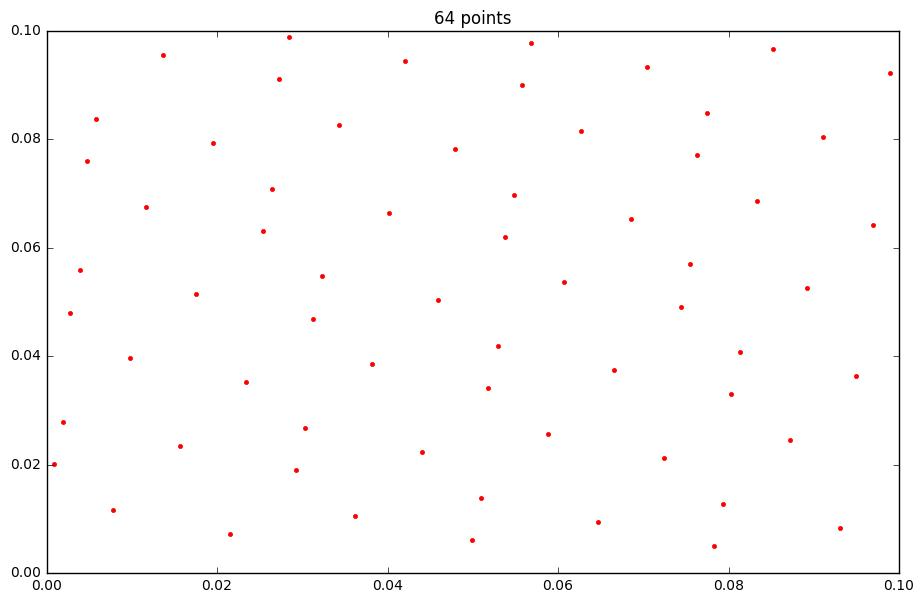

In [7]:
ppp(points, fmt = 'r.')

In [8]:
raster_prec = 512 #1024

In [9]:
def julia_inverse(p):
    c = -0.512511498387847167 + 0.521295573094847167j
    z = cm.sqrt(p-c)
    return [z, -z]
def rasterize(p):
    x, y = p.real, p.imag
    x = round(x*raster_prec)/raster_prec
    y = round(y*raster_prec)/raster_prec
    return x + y*1j

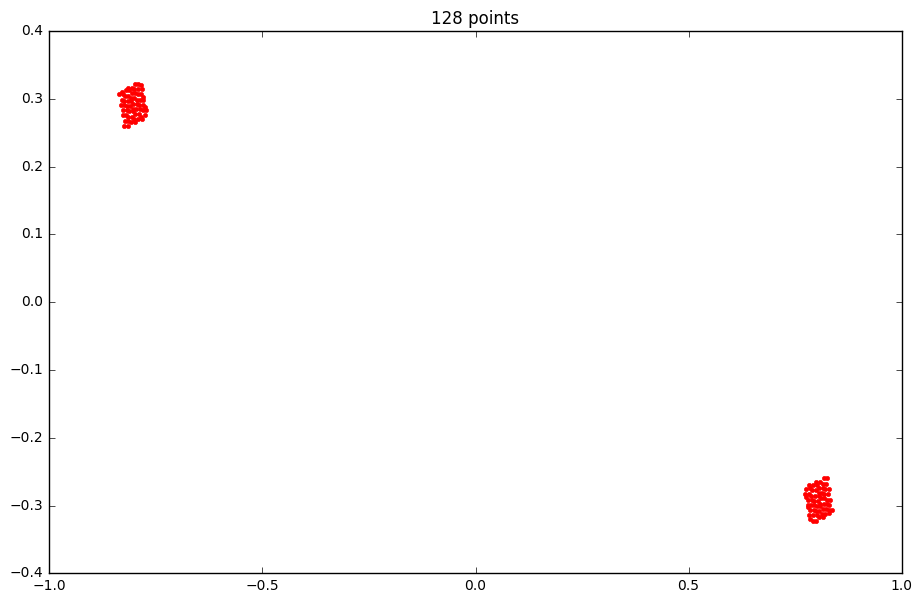

In [10]:
ppp(set(map(rasterize, i.chain(*map(julia_inverse, points)))), fmt='r.')

In [11]:
def iterate(ps):
    return set(map(rasterize, i.chain(*map(julia_inverse, ps))))

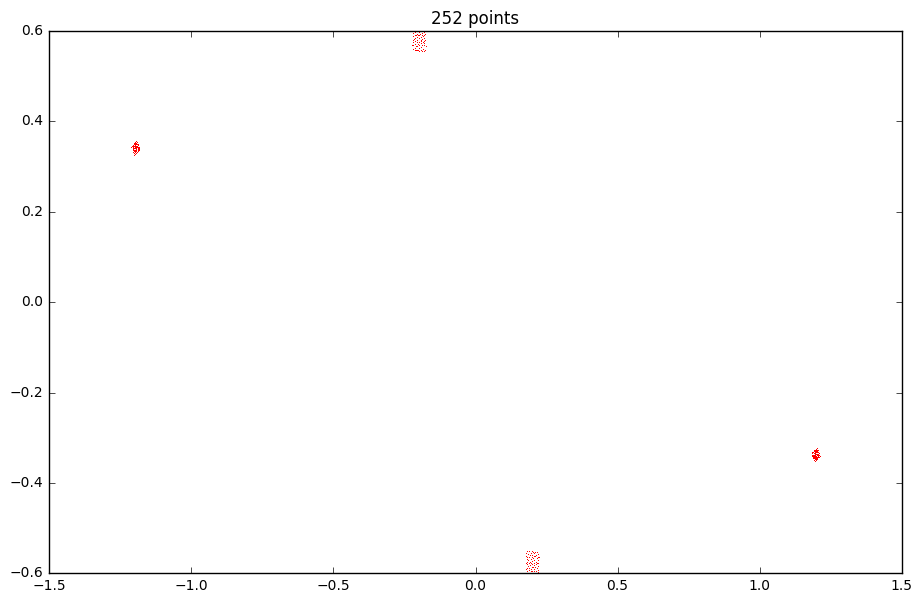

In [12]:
ppp(iterate(iterate(points)))

In [13]:
def iterateN(n, iterfunc, ps):
    p = ps
    for i in range(n):
        p = iterfunc(p)
    return p

In [14]:
def iterateP(n, iterfunc, ps):
    r = m.ceil(m.sqrt(n))
    c = m.ceil(n/r)
    p = ps
    #plt.figure(figsize=(15,12))
    for i in range(n):
        plt.subplot(r,c,i+1)
        ppp(p, i)
        if i == n-1: break
        p = iterfunc(p)
    plt.show()

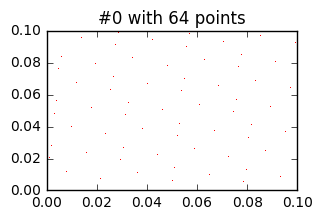

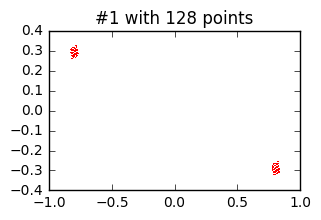

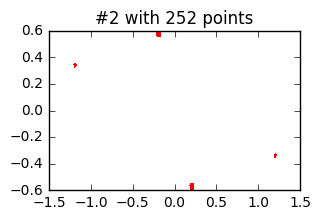

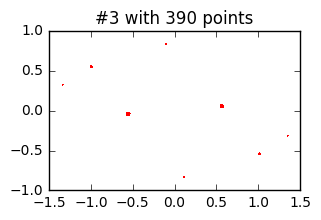

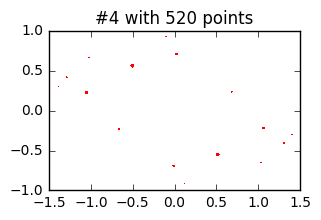

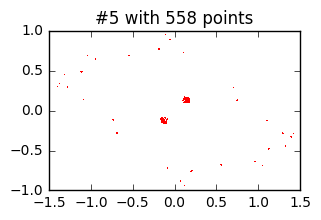

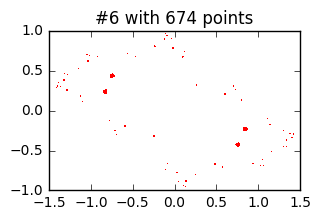

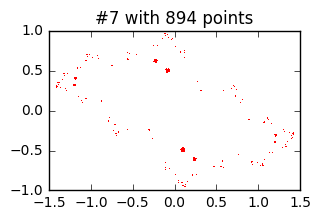

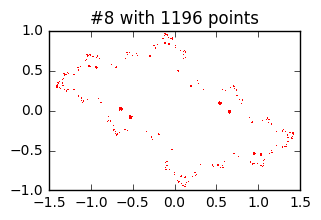

9.451832679915242

In [15]:
tt("iterateP(9,iterate,points)","from __main__ import iterateP, iterate, points")

In [16]:
def refine(n,ps):
    p = ps
    fp = set()
    i = 0
    while True:
        print("iter {}  len(p) = {}".format(i,len(p)))
        p = iterateN(n,iterate,p)
        p.difference_update(fp)
        if len(p) == 0: break
        fp.update(p)
        i = i+1
    return fp

iter 0  len(p) = 64
iter 1  len(p) = 1196
iter 2  len(p) = 11038
iter 3  len(p) = 16146
iter 4  len(p) = 11258
iter 5  len(p) = 10318
iter 6  len(p) = 14090
iter 7  len(p) = 17026
iter 8  len(p) = 14094
iter 9  len(p) = 10458
iter 10  len(p) = 9336
iter 11  len(p) = 8802
iter 12  len(p) = 7388
iter 13  len(p) = 5686
iter 14  len(p) = 4606
iter 15  len(p) = 3660
iter 16  len(p) = 2906
iter 17  len(p) = 2190
iter 18  len(p) = 1794
iter 19  len(p) = 1540
iter 20  len(p) = 1322
iter 21  len(p) = 1074
iter 22  len(p) = 812
iter 23  len(p) = 614
iter 24  len(p) = 544
iter 25  len(p) = 360
iter 26  len(p) = 344
iter 27  len(p) = 262
iter 28  len(p) = 214
iter 29  len(p) = 132
iter 30  len(p) = 56
iter 31  len(p) = 50
iter 32  len(p) = 40
iter 33  len(p) = 44
iter 34  len(p) = 82
iter 35  len(p) = 38
iter 36  len(p) = 50
iter 37  len(p) = 42
iter 38  len(p) = 58
iter 39  len(p) = 18


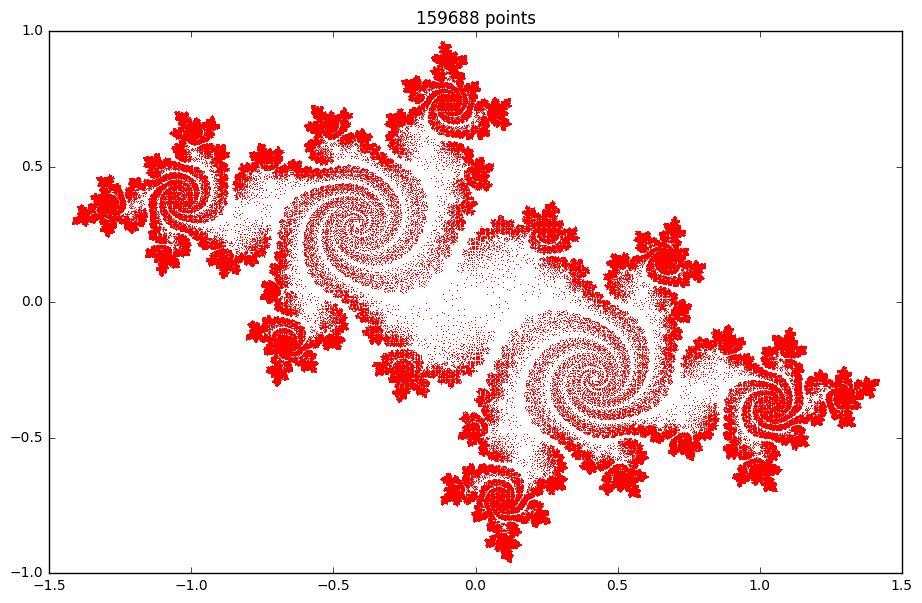

172.9348879950121

In [17]:
tt("ppp(refine(8,points))",
   "from __main__ import ppp,refine,points")

# Port the code to Apache Spark

In [18]:
sc  # Automatically defined in PySparkShell, which is launched via $SPARK_HOME/bin/pyspark

<SparkContext master=spark://nid03834:7077 appName=PySparkShell>

In [19]:
sc.getConf().getAll()

[('spark.driver.memory', '32g'),
 ('spark.task.cpus', '4'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.extraJavaOptions',
  '-XX:+UseParallelGC -XX:ParallelGCThreads=8'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.driver.host', 'nid03834'),
 ('spark.rpc.netty.dispatcher.numThreads', '8'),
 ('spark.executor.memory', '32g'),
 ('spark.executor.extraJavaOptions',
  '-XX:+UseParallelGC -XX:ParallelGCThreads=8'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.port', '35481'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'spark://nid03834:7077'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'app-20190327150035-0000')]

In [20]:
n_rdd = sc.range(1,2**6+1)

In [21]:
import socket, os

In [22]:
n_rdd.map(lambda x: (socket.gethostname(), os.getppid(), os.getpid())).distinct().collect()

[('nid03835', 27968, 28145),
 ('nid03834', 134290, 134705),
 ('nid03835', 27968, 28010),
 ('nid03835', 27968, 28335),
 ('nid03835', 27968, 28925),
 ('nid03834', 134290, 134909),
 ('nid03835', 27968, 28966),
 ('nid03835', 27968, 28445),
 ('nid03835', 27968, 28154),
 ('nid03835', 27968, 28625),
 ('nid03835', 27968, 28850),
 ('nid03835', 27968, 28021),
 ('nid03835', 27968, 28650),
 ('nid03834', 134290, 135240),
 ('nid03835', 27968, 28029),
 ('nid03834', 134290, 135691),
 ('nid03834', 134290, 134674),
 ('nid03834', 134290, 134968),
 ('nid03835', 27968, 28465),
 ('nid03835', 27968, 28265),
 ('nid03835', 27968, 28148),
 ('nid03835', 27968, 28911),
 ('nid03834', 134290, 134628),
 ('nid03834', 134290, 135825),
 ('nid03834', 134290, 134801),
 ('nid03834', 134290, 135787),
 ('nid03834', 134290, 134855),
 ('nid03834', 134290, 135726),
 ('nid03834', 134290, 134835),
 ('nid03835', 27968, 28535),
 ('nid03834', 134290, 135206),
 ('nid03835', 27968, 28250),
 ('nid03835', 27968, 28710),
 ('nid03834', 1

In [23]:
points_rdd = n_rdd.map(lambda n: (n/rho %1)/10 + (n/(rho*rho) %1)/10*1j).cache()  # Mark for cache() in memory

In [24]:
points_rdd.getNumPartitions()

512

In [25]:
points_rdd.glom().map(len).collect()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,


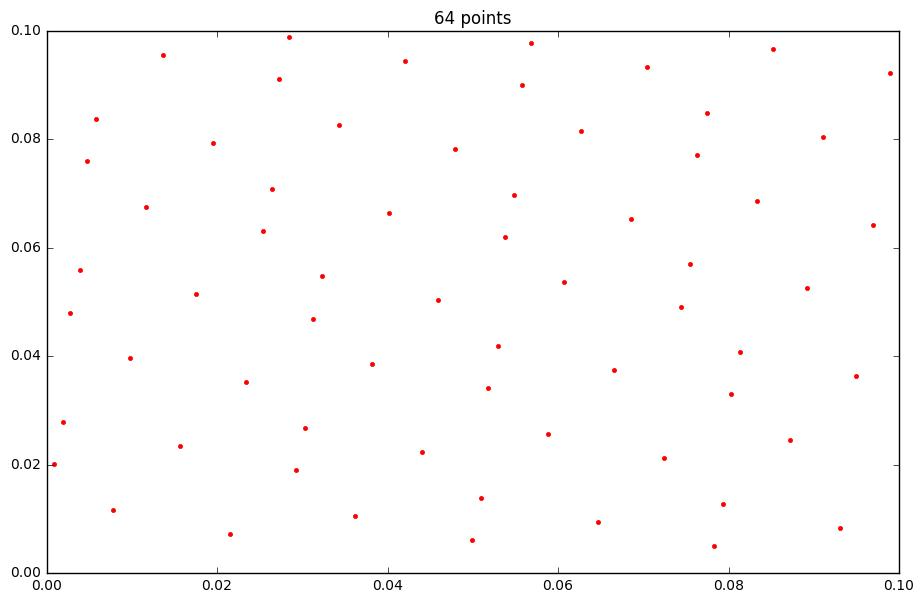

In [26]:
ppp(points_rdd.collect(), fmt = 'r.')

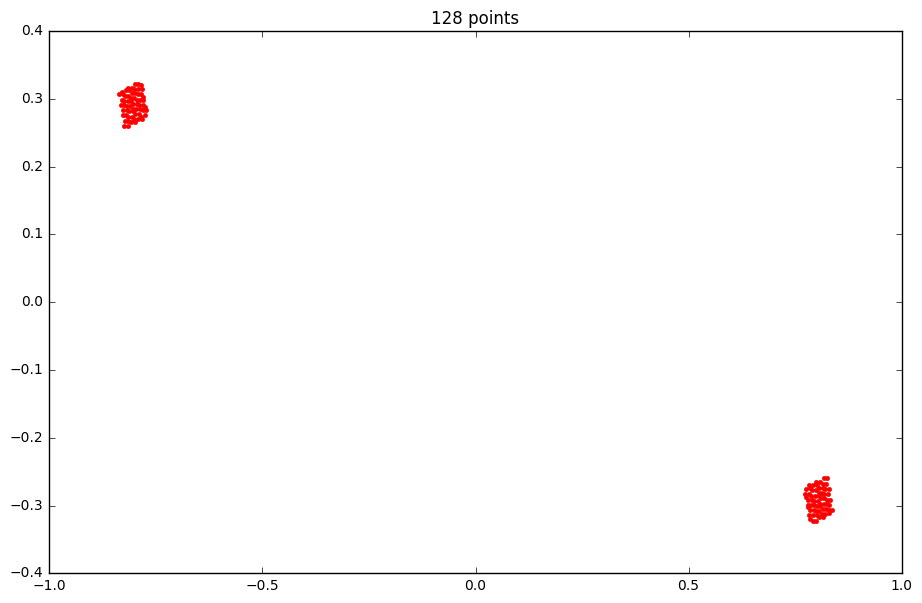

In [27]:
ppp(points_rdd.flatMap(julia_inverse, True).map(rasterize, True).distinct().collect(), fmt="r.")

In [28]:
def iterate_rdd(ps):
    # We need repartition() after distinct() for balancing parallel workload.
    return ps.flatMap(julia_inverse, True).map(rasterize, True).distinct().repartition(ps.getNumPartitions())

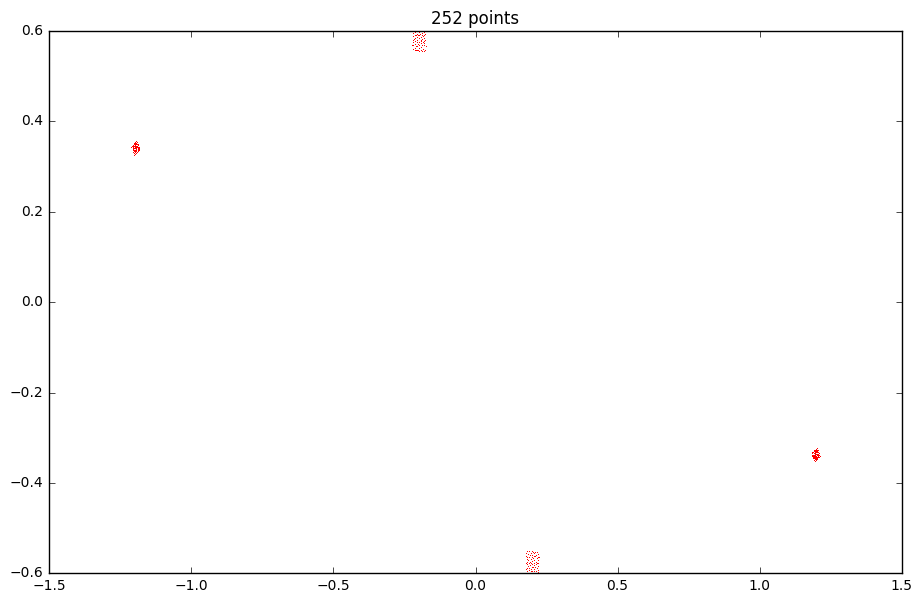

In [29]:
ppp(iterate_rdd(iterate_rdd(points_rdd)).collect())

In [30]:
def iterateP_rdd(n, iterfunc, ps):
    r = m.ceil(m.sqrt(n))
    c = m.ceil(n/r)
    p = ps
    #plt.figure(figsize=(15,12))
    for i in range(n):
        plt.subplot(r,c,i+1)
        ppp(p.collect(), i)
        if i == n-1: break
        p = iterfunc(p).cache()
    plt.show()

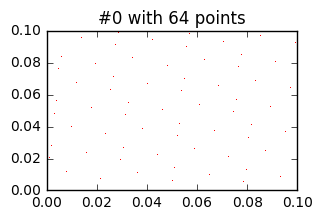

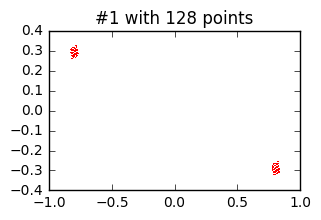

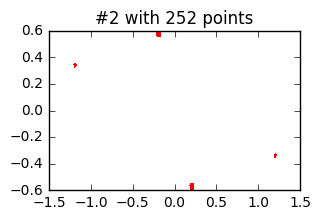

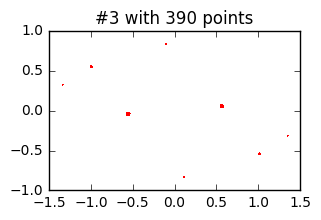

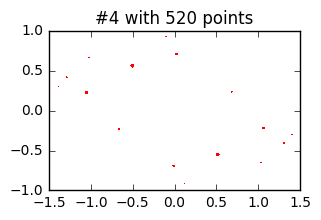

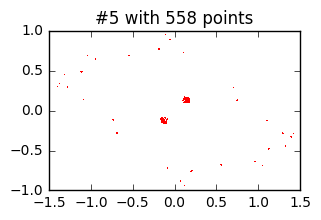

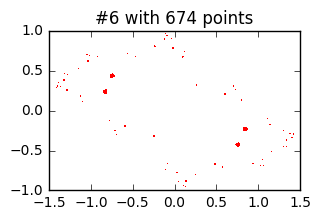

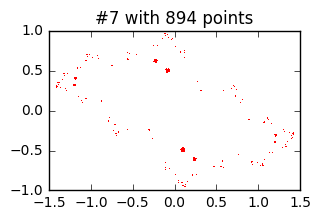

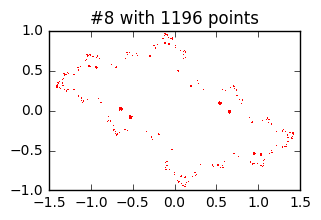

33.20690138707869

In [31]:
tt("iterateP_rdd(9,iterate_rdd,points_rdd)",
   "from __main__ import iterateP_rdd, iterate_rdd, points_rdd")

In [34]:
def refine_rdd(n,ps):
    np = ps.getNumPartitions()
    p = ps
    fp = sc.emptyRDD()
    i = 0
    while True:
        print("iter {}  len(p) = {}".format(i,p.count()))
        #print(f"iter {i}  p {p.glom().map(len).collect()}  fp {fp.glom().map(len).collect()}")
        p = iterateN(n,iterate_rdd,p).subtract(fp).cache()
        if p.isEmpty(): break
        p = p.repartition(min(np,m.ceil(p.count()/10))).cache()  # Try removing the repartition call here and below.
        fp = fp.union(p).repartition(np).cache()
        i = i+1
    return fp

iter 0  len(p) = 64
iter 1  len(p) = 1196
iter 2  len(p) = 11038
iter 3  len(p) = 16146
iter 4  len(p) = 11258
iter 5  len(p) = 10318
iter 6  len(p) = 14090
iter 7  len(p) = 17026
iter 8  len(p) = 14094
iter 9  len(p) = 10458
iter 10  len(p) = 9336
iter 11  len(p) = 8802
iter 12  len(p) = 7388
iter 13  len(p) = 5686
iter 14  len(p) = 4606
iter 15  len(p) = 3660
iter 16  len(p) = 2906
iter 17  len(p) = 2190
iter 18  len(p) = 1794
iter 19  len(p) = 1540
iter 20  len(p) = 1322
iter 21  len(p) = 1074
iter 22  len(p) = 812
iter 23  len(p) = 614
iter 24  len(p) = 544
iter 25  len(p) = 360
iter 26  len(p) = 344
iter 27  len(p) = 262
iter 28  len(p) = 214
iter 29  len(p) = 132
iter 30  len(p) = 56
iter 31  len(p) = 50
iter 32  len(p) = 40
iter 33  len(p) = 44
iter 34  len(p) = 82
iter 35  len(p) = 38
iter 36  len(p) = 50
iter 37  len(p) = 42
iter 38  len(p) = 58
iter 39  len(p) = 18


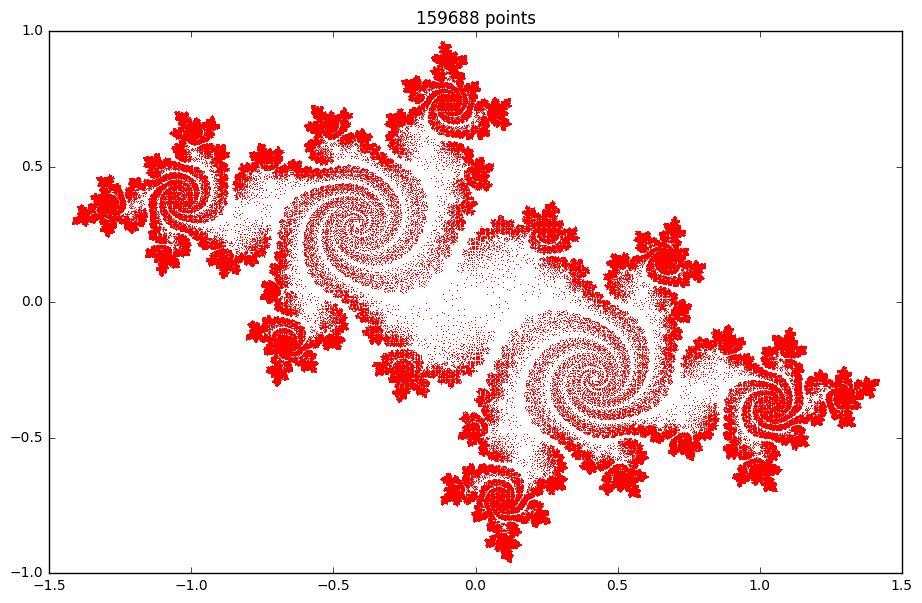

1210.1628025000682

In [35]:
tt("ppp(refine_rdd(8,points_rdd).collect())",
   "from __main__ import ppp,refine_rdd,points_rdd")